In [1]:
%load_ext autoreload
%autoreload 2
from geolifeclef.utils import get_spark
from pyspark.sql import functions as F

spark = get_spark(memory="24g", executor_memory="1g")
metadata = spark.read.parquet(
    "../../data/geolifeclef-2024/data/processed/metadata_clean/v1"
)
metadata.printSchema()
metadata.show()

24/04/26 16:48:19 WARN Utils: Your hostname, daphne-major resolves to a loopback address: 127.0.1.1; using 172.28.199.217 instead (on interface eth0)
24/04/26 16:48:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/26 16:48:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/26 16:48:20 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


root
 |-- dataset: string (nullable = true)
 |-- surveyId: integer (nullable = true)
 |-- lat_proj: double (nullable = true)
 |-- lon_proj: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- geoUncertaintyInM: double (nullable = true)
 |-- speciesId: double (nullable = true)

+--------+--------+-------------------+--------------------+---------+---------+----+-----------------+---------+
| dataset|surveyId|           lat_proj|            lon_proj|      lat|      lon|year|geoUncertaintyInM|speciesId|
+--------+--------+-------------------+--------------------+---------+---------+----+-----------------+---------+
|pa_train| 1154667|-1532011.0411057267| 1.691006027258277E7| 57.41102|  10.1656|2018|             10.0|   5928.0|
|      po|  328943|-1238969.8380109437|1.6157490707117997E7| 52.66047|  19.0257|2021|              4.0|   8654.0|
|      po|  272993| -3131000.345551669|1.5794519571905952E7| 42.706

In [2]:
from pyspark.ml.linalg import SparseVector, VectorUDT
from collections import Counter


def _collect_sparse_labels(array):
    """Turn a list of numbers into a sparse vector."""
    max_species = 11255

    @F.udf(VectorUDT())
    def func(array):
        if not array:
            return SparseVector(max_species, [])
        return SparseVector(max_species, sorted(Counter(array).items()))

    return func(array)


df = (
    (
        metadata.where(F.col("dataset") == "pa_train")
        .groupBy("surveyId")
        .agg(
            F.mean("lat_proj").alias("lat_proj"),
            F.mean("lon_proj").alias("lon_proj"),
            _collect_sparse_labels(F.collect_list("speciesId")).alias("labels_sp"),
            F.sort_array(F.collect_set("speciesId")).alias("labels"),
        )
        .withColumn("sample_id", F.crc32(F.col("surveyId").cast("string")) % 100)
        .withColumn("is_validation", F.col("sample_id") < 10)
        .withColumn("is_train", F.col("sample_id") < 80)
        .withColumn("is_test", F.col("sample_id") >= 80)
    )
    .sample(0.1)
    .orderBy("surveyId")
    .cache()
)
print(df.count())
df.show()

8827
+--------+-------------------+--------------------+--------------------+--------------------+---------+-------------+--------+-------+
|surveyId|           lat_proj|            lon_proj|           labels_sp|              labels|sample_id|is_validation|is_train|is_test|
+--------+-------------------+--------------------+--------------------+--------------------+---------+-------------+--------+-------+
|     324|-3149612.3055191883|1.5932557464872137E7|(11255,[146,694,2...|[146.0, 694.0, 23...|       19|        false|    true|  false|
|    1386|-1670374.6755718412|1.6802366936806973E7|(11255,[540,1007,...|[540.0, 1007.0, 1...|       15|        false|    true|  false|
|    1972|   -2804658.0070795|1.5718302223575212E7|(11255,[812,2101,...|[812.0, 2101.0, 3...|        7|         true|    true|  false|
|    2106|-1604250.3288380972| 1.680909601460762E7|(11255,[890,1288,...|[890.0, 1288.0, 2...|       55|        false|    true|  false|
|    2334|  -1689721.50558798|1.6759126457023865E7

In [9]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

scaled_labels = (
    StandardScaler(
        inputCol="labels_sp", outputCol="labels_centered", withStd=False, withMean=True
    )
    .fit(df)
    .transform(df)
)

In [10]:
# compute svd using the labels_sp column
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.linalg import Vectors
from contexttimer import Timer

# convert to a sparse matrix
X = RowMatrix(
    scaled_labels.rdd.map(lambda x: Vectors.fromML(x.labels_centered)).cache()
)
with Timer() as t:
    svd = X.computeSVD(2, computeU=True)
    print(svd.s)
    print(svd.V.toArray().shape)
    print(svd.U.rows)
    # pca = X.computePrincipalComponents(16)
    # print(pca)

print(f"svd computed in {t.elapsed:.2f}s")

24/04/26 16:53:05 WARN RowMatrix: The input data is not directly cached, which may hurt performance if its parent RDDs are also uncached.


(2,)
(11255, 2)
MapPartitionsRDD[723] at mapPartitions at PythonMLLibAPI.scala:1344
svd computed in 632.29s


24/04/26 17:03:37 WARN RowMatrix: The input data was not directly cached, which may hurt performance if its parent RDDs are also uncached.


In [23]:
labels_svd = (
    svd.U.rows.zipWithIndex()
    .map(lambda x: (x[1], x[0]))
    .toDF(["index", "labels_svd"])
    .join(
        df.select("surveyId")
        .rdd.zipWithIndex()
        .map(lambda x: (x[1], x[0].surveyId))
        .toDF(["index", "surveyId"]),
        on="index",
    )
    .cache()
)
labels_svd.printSchema()
labels_svd.show(n=5, truncate=80)

root
 |-- index: long (nullable = true)
 |-- labels_svd: vector (nullable = true)
 |-- surveyId: long (nullable = true)



+-----+-----------------------------------------------+--------+
|index|                                     labels_svd|surveyId|
+-----+-----------------------------------------------+--------+
|   26|[-0.0012239016830767604,-0.0031386351435631326]|    9921|
|   29| [0.0015400241143383457,-1.7080874066696192E-4]|   11673|
|  474| [-4.7661418031372336E-4,0.0027418495795976236]|  210214|
|  964| [0.0025135329501477116,-0.0021007904629293324]|  430906|
| 1677| [0.0013939416632202742,-0.0023393407556751133]|  751765|
+-----+-----------------------------------------------+--------+
only showing top 5 rows



(8827, 2)


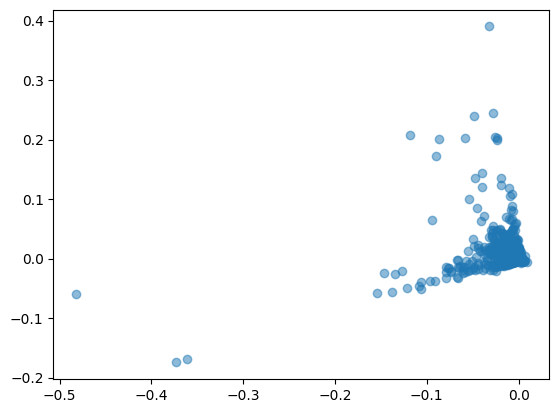

In [15]:
import matplotlib.pyplot as plt
import numpy as np

U = np.stack(labels_svd.toPandas().labels_svd)
print(U.shape)
plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

In [16]:
from pynndescent import NNDescent

index = NNDescent(U, metric="cosine")

In [19]:
# test a query
indices, distances = index.query(U[:1], k=10)
print(indices, distances)

[[   0 8414  984 4726 8180 2960 3313 7209 1316  313]] [[0.00000000e+00 1.19209271e-07 1.19209271e-07 2.98022332e-06
  7.98695839e-06 9.53665233e-06 1.10863407e-05 1.19207870e-05
  1.19207870e-05 1.53777621e-05]]


In [24]:
from pyspark.sql import Row
from pyspark.ml.linalg import DenseVector

full = df.join(labels_svd, on="surveyId")
full.show()
full.printSchema()

+--------+-------------------+--------------------+--------------------+--------------------+---------+-------------+--------+-------+-----+--------------------+
|surveyId|           lat_proj|            lon_proj|           labels_sp|              labels|sample_id|is_validation|is_train|is_test|index|          labels_svd|
+--------+-------------------+--------------------+--------------------+--------------------+---------+-------------+--------+-------+-----+--------------------+
|     324|-3149612.3055191883|1.5932557464872137E7|(11255,[146,694,2...|[146.0, 694.0, 23...|       19|        false|    true|  false|    0|[7.67895194847147...|
|    1386|-1670374.6755718412|1.6802366936806973E7|(11255,[540,1007,...|[540.0, 1007.0, 1...|       15|        false|    true|  false|    1|[0.00224221987270...|
|    1972|   -2804658.0070795|1.5718302223575212E7|(11255,[812,2101,...|[812.0, 2101.0, 3...|        7|         true|    true|  false|    2|[4.72068119200717...|
|    2106|-1604250.328838097

In [25]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from xgboost.spark import SparkXGBRegressor
import os
from geolifeclef.workflows.model.transformer import ExtractLabelsFromVector

pipeline = Pipeline(
    stages=[
        VectorAssembler(inputCols=["lat_proj", "lon_proj"], outputCol="features"),
        StandardScaler(inputCol="features", outputCol="features_scaled"),
        ExtractLabelsFromVector(
            inputCol="labels_svd",
            outputColPrefix="labels_svd",
            indexDim=2,
        ),
        *[
            SparkXGBRegressor(
                features_col="features_scaled",
                label_col=f"labels_svd_{i:03d}",
                prediction_col=f"prediction_{i:03d}",
                num_workers=os.cpu_count(),
                early_stopping_rounds=10,
                validation_indicator_col="is_validation",
                multi_strategy="multi_output_tree",
            )
            for i in range(2)
        ],
        VectorAssembler(
            inputCols=[f"prediction_{i:03d}" for i in range(2)],
            outputCol="prediction",
        ),
    ]
)

model = pipeline.fit(full.where("is_train"))
predictions = model.transform(full).drop("labels_sp", "labels_sp_scaled").cache()
predictions.printSchema()
predictions.show()

2024-04-26 17:20:20,685 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 32 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'multi_strategy': 'multi_output_tree', 'nthread': 1}
	train_call_kwargs_params: {'early_stopping_rounds': 10, 'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[17:20:24] task 12 got new rank 0                                 (0 + 32) / 32]
[17:20:24] task 31 got new rank 1
[17:20:24] task 13 got new rank 2
[17:20:24] task 5 got new rank 3
[17:20:24] task 9 got new rank 4
[17:20:25] task 15 got new rank 5
[17:20:25] task 0 got new rank 6
[17:20:25] task 17 got new rank 7
[17:20:25] task 19 got new rank 8
[17:20:25] task 25 got new rank 9
[17:20:25] task 30 got new rank 10
[17:20:25] task 18 got new rank 11
[17:20:25] task 29 got new rank 12
[17:20:25] task 2 got new rank 13
[17:20:25] task 24 got new rank 14
[17:20:26] task 7 got new rank 15
[17:20:26] task 4 got new rank 16
[17:20:26]

root
 |-- surveyId: integer (nullable = true)
 |-- lat_proj: double (nullable = true)
 |-- lon_proj: double (nullable = true)
 |-- labels: array (nullable = false)
 |    |-- element: double (containsNull = false)
 |-- sample_id: long (nullable = true)
 |-- is_validation: boolean (nullable = true)
 |-- is_train: boolean (nullable = true)
 |-- is_test: boolean (nullable = true)
 |-- index: long (nullable = true)
 |-- labels_svd: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_scaled: vector (nullable = true)
 |-- labels_svd_000: double (nullable = true)
 |-- labels_svd_001: double (nullable = true)
 |-- prediction_000: double (nullable = true)
 |-- prediction_001: double (nullable = true)
 |-- prediction: vector (nullable = true)



2024-04-26 17:20:36,508 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-04-26 17:20:36,510 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-04-26 17:20:36,514 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-04-26 17:20:36,515 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-04-26 17:20:36,519 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-04-26 17:20:36,522 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-04-26 17:20:36,523 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-04-26 17:20:36,525 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-04-26 17:20:36,526 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-04-26 17:20:36,526 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-04-26 17:20:36,527 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on th

+--------+-------------------+--------------------+--------------------+---------+-------------+--------+-------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|surveyId|           lat_proj|            lon_proj|              labels|sample_id|is_validation|is_train|is_test|index|          labels_svd|            features|     features_scaled|      labels_svd_000|      labels_svd_001|      prediction_000|      prediction_001|          prediction|
+--------+-------------------+--------------------+--------------------+---------+-------------+--------+-------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     324|-3149612.3055191883|1.5932557464872137E7|[146.0, 694.0, 23...|       19|        false|    true|  false|    0|[7.67895194847147

2024-04-26 17:20:41,787 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


In [26]:
# get rmse of the prediction
from pyspark.ml.evaluation import RegressionEvaluator, MultilabelClassificationEvaluator
import numpy as np

# get rmse of the first dimension and the second dimension
evaluator = RegressionEvaluator(
    predictionCol="prediction_000", labelCol="labels_svd_000", metricName="rmse"
)
rmse = evaluator.evaluate(predictions)
rmse

0.007672796559034291

In [27]:
# now the real prediction is the closest neighbor to each prediction
# broadcast the index to use in a udf
import numpy as np
from pyspark.ml.functions import vector_to_array

pdf = predictions.select(vector_to_array("prediction").alias("prediction")).toPandas()
# np.stack(pdf.prediction.values)
idx, dist = index.query(np.stack(pdf.prediction.values), k=3)

In [45]:
# now map these back to the species

labels_svd.printSchema()

pred_labels = (
    spark.createDataFrame(
        [Row(index=i, pred_index=int(row[0])) for i, row in enumerate(idx)]
    )
    .join(predictions.select("index", "surveyId", "labels"), on="index")
    .join(
        predictions.select(
            F.col("index").alias("pred_index"), F.col("labels").alias("pred_labels")
        ),
        on="pred_index",
    )
)

# now evaluate
MultilabelClassificationEvaluator(
    predictionCol="pred_labels", labelCol="labels", metricName="microF1Measure"
).evaluate(pred_labels)

root
 |-- index: long (nullable = true)
 |-- labels_svd: vector (nullable = true)
 |-- surveyId: long (nullable = true)



0.09772195161333729